In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import datetime,sys,os
import pickle
from sklearn.externals import joblib

from sklearn.metrics import mean_squared_error

# For Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

from numpy import array
from keras.models import Model,Sequential,load_model,model_from_json
from keras.layers import LSTM, Input, Flatten, Dense, Dropout, Bidirectional
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from keras.layers.merge import concatenate
from keras.utils import plot_model

/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [8]:
data3 = pd.read_csv("datasets/data3.csv")
data3.head()

,id,bond_id,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,...,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,1,1,128.596,11.316404,5.95,26.031126,0,1.731,120000,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,126.673,8.763446,5.95,26.016697,0,30.518,85000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,126.880,6.499730,5.95,26.008760,0,4.424,4200000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,126.362,0.865854,5.95,26.008619,0,43.059,5000001,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,124.918,11.938543,5.95,25.981840,0,6.332,10000,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data3.isnull().sum()

id                               0
bond_id                          0
trade_price                      0
weight                           0
current_coupon                   0
time_to_maturity                 0
is_callable                      0
reporting_delay                  0
trade_size                       0
trade_type                       0
curve_based_price                0
received_time_diff_last1         0
trade_price_last1                0
trade_size_last1                 0
trade_type_last1                 0
curve_based_price_last1         39
received_time_diff_last2      2000
trade_price_last2             2000
trade_size_last2              2000
trade_type_last2              2000
curve_based_price_last2       2076
received_time_diff_last3      3970
trade_price_last3             3970
trade_size_last3              3970
trade_type_last3              3970
curve_based_price_last3       4082
received_time_diff_last4      5922
trade_price_last4             5922
trade_size_last4    

In [12]:
data3.shape

(762678, 61)

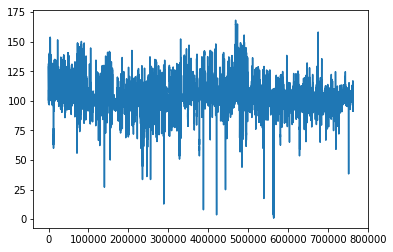

In [15]:
data3["trade_price"].plot()

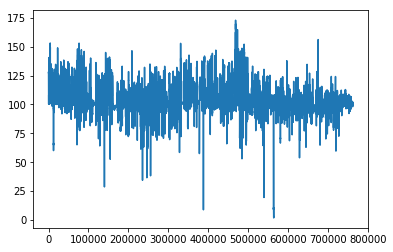

In [16]:
data3["curve_based_price"].plot()

## LSTM

In [72]:
def get_model_params():
    batch_size = 10000
    no_epochs = 20
    return no_epochs,batch_size

In [73]:
def get_model_data(data, datafile):
    train_size = int(data.shape[0] * 0.75)
    train, test = train_test_splitter(data, train_size)
    
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train.reshape((train.shape[0],1)))
    test = scaler.transform(test.reshape((test.shape[0],1)))
    
    scaler_filename = "scaler"+str(datafile[-1])+".save"
    scaler_path = "Scalers/" + scaler_filename
    joblib.dump(scaler, scaler_path)
    
    no_epochs,batch_size,n_steps,n_features = get_model_params(datafile)
    X_train, y_train = split_sequence(train, n_steps)
    X_test, y_test = split_sequence(test, n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
    return no_epochs,batch_size,n_steps,n_features,X_train, X_test, y_train, y_test

## Modelling for data3:

In [83]:
data3.head()

,id,bond_id,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,...,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,1,1,128.596,11.316404,5.95,26.031126,0,1.731,120000,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,126.673,8.763446,5.95,26.016697,0,30.518,85000,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,126.880,6.499730,5.95,26.008760,0,4.424,4200000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,126.362,0.865854,5.95,26.008619,0,43.059,5000001,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,124.918,11.938543,5.95,25.981840,0,6.332,10000,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
data3.isnull().sum()

id                               0
bond_id                          0
trade_price                      0
weight                           0
current_coupon                   0
time_to_maturity                 0
is_callable                      0
reporting_delay                  0
trade_size                       0
trade_type                       0
curve_based_price                0
received_time_diff_last1         0
trade_price_last1                0
trade_size_last1                 0
trade_type_last1                 0
curve_based_price_last1         39
received_time_diff_last2      2000
trade_price_last2             2000
trade_size_last2              2000
trade_type_last2              2000
curve_based_price_last2       2076
received_time_diff_last3      3970
trade_price_last3             3970
trade_size_last3              3970
trade_type_last3              3970
curve_based_price_last3       4082
received_time_diff_last4      5922
trade_price_last4             5922
trade_size_last4    

In [85]:
data3['bond_id'].nunique()

3736

In [86]:
ser = data3['bond_id'].value_counts()
ser[ser > 1].count()

3651

In [87]:
data3['is_callable'].nunique()

2

In [88]:
data3['current_coupon'].nunique()

408

In [89]:
data3['trade_type'].nunique()

3

In [90]:
d3 = data3.fillna(0)

In [91]:
cols = d3.columns
cols

Index(['id', 'bond_id', 'trade_price', 'weight', 'current_coupon',
       'time_to_maturity', 'is_callable', 'reporting_delay', 'trade_size',
       'trade_type', 'curve_based_price', 'received_time_diff_last1',
       'trade_price_last1', 'trade_size_last1', 'trade_type_last1',
       'curve_based_price_last1', 'received_time_diff_last2',
       'trade_price_last2', 'trade_size_last2', 'trade_type_last2',
       'curve_based_price_last2', 'received_time_diff_last3',
       'trade_price_last3', 'trade_size_last3', 'trade_type_last3',
       'curve_based_price_last3', 'received_time_diff_last4',
       'trade_price_last4', 'trade_size_last4', 'trade_type_last4',
       'curve_based_price_last4', 'received_time_diff_last5',
       'trade_price_last5', 'trade_size_last5', 'trade_type_last5',
       'curve_based_price_last5', 'received_time_diff_last6',
       'trade_price_last6', 'trade_size_last6', 'trade_type_last6',
       'curve_based_price_last6', 'received_time_diff_last7',
       '

In [92]:
time_cols = ['received_time_diff_last1',
       'trade_price_last1', 'trade_size_last1', 'trade_type_last1',
       'curve_based_price_last1', 'received_time_diff_last2',
       'trade_price_last2', 'trade_size_last2', 'trade_type_last2',
       'curve_based_price_last2', 'received_time_diff_last3',
       'trade_price_last3', 'trade_size_last3', 'trade_type_last3',
       'curve_based_price_last3', 'received_time_diff_last4',
       'trade_price_last4', 'trade_size_last4', 'trade_type_last4',
       'curve_based_price_last4', 'received_time_diff_last5',
       'trade_price_last5', 'trade_size_last5', 'trade_type_last5',
       'curve_based_price_last5', 'received_time_diff_last6',
       'trade_price_last6', 'trade_size_last6', 'trade_type_last6',
       'curve_based_price_last6', 'received_time_diff_last7',
       'trade_price_last7', 'trade_size_last7', 'trade_type_last7',
       'curve_based_price_last7', 'received_time_diff_last8',
       'trade_price_last8', 'trade_size_last8', 'trade_type_last8',
       'curve_based_price_last8', 'received_time_diff_last9',
       'trade_price_last9', 'trade_size_last9', 'trade_type_last9',
       'curve_based_price_last9', 'received_time_diff_last10',
       'trade_price_last10', 'trade_size_last10', 'trade_type_last10',
       'curve_based_price_last10']

In [93]:
num_cols = ['weight','current_coupon','time_to_maturity','reporting_delay','trade_size','curve_based_price']

In [94]:
non_ts_cols = d3.columns[~d3.columns.str.contains(pat = "_last")]
non_ts_cols

Index(['id', 'bond_id', 'trade_price', 'weight', 'current_coupon',
       'time_to_maturity', 'is_callable', 'reporting_delay', 'trade_size',
       'trade_type', 'curve_based_price'],
      dtype='object')

In [95]:
id_cols = d3.columns[d3.columns.str.contains(pat = "id")]
id_cols

Index(['id', 'bond_id'], dtype='object')

In [96]:
cat_cols = ['is_callable','trade_type']

In [97]:
target_col = "trade_price"

In [98]:
ts_cols = ["trade_size_last","trade_price_last","received_time_diff_last","trade_type_last","curve_based_price_last"]

In [99]:
working_cols = [col for col in cols if col not in id_cols]

In [100]:
working_cols = [col for col in working_cols if col not in d3.columns[d3.columns.str.contains(pat = "_last")]]

In [101]:
working_cols

['trade_price',
 'weight',
 'current_coupon',
 'time_to_maturity',
 'is_callable',
 'reporting_delay',
 'trade_size',
 'trade_type',
 'curve_based_price']

count    762678.000000
mean        103.440546
std           9.824289
min           1.009000
25%          99.433000
50%         102.300000
75%         107.110000
max         168.148000
Name: trade_price, dtype: float64


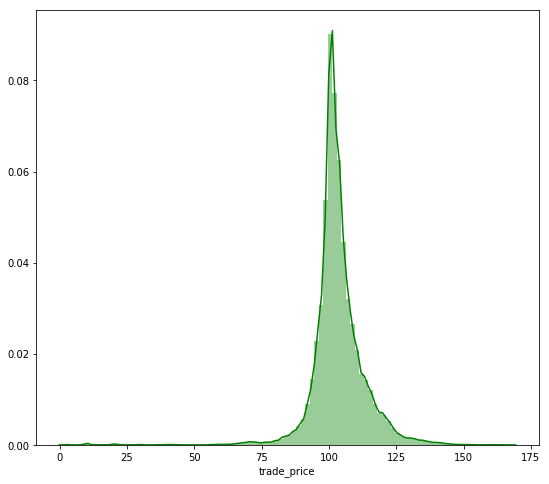

In [102]:
print(data3['trade_price'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(data3['trade_price'], color='g', bins=100, hist_kws={'alpha': 0.4});

### Not much Outliers in trade_price

In [103]:
data3[num_cols].describe()

,weight,current_coupon,time_to_maturity,reporting_delay,trade_size,curve_based_price
count,762678.000000,762678.000000,762678.000000,7.626780e+05,7.626780e+05,762678.000000
mean,0.983026,5.588142,6.564305,2.823761e+04,2.672078e+05,103.219652
std,2.164972,1.724374,6.267664,1.064998e+06,7.725859e+05,9.932693
min,0.012991,0.000000,0.082471,-5.858100e+01,1.000000e+00,1.746127
25%,0.036745,4.750000,2.493513,2.491000e+00,1.000000e+04,98.899486
50%,0.220471,5.625000,4.775924,9.438000e+00,2.500000e+04,102.121523
75%,0.736710,6.500000,8.258087,3.496775e+01,1.000000e+05,106.988161
max,42.896223,13.500000,84.159498,9.987914e+07,5.000001e+06,172.956162


In [104]:
data3_num = data3[num_cols]
data3_num['trade_price'] = data3['trade_price']
data3_num_corr = data3_num.corr()['trade_price'][:-1]
corr_features_list = data3_num_corr[abs(data3_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with trade_price:\n{}".format(len(corr_features_list), corr_features_list))

There is 1 strongly correlated values with trade_price:
curve_based_price    0.990686
Name: trade_price, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faf6ee4e9b0>,
      dtype=object)

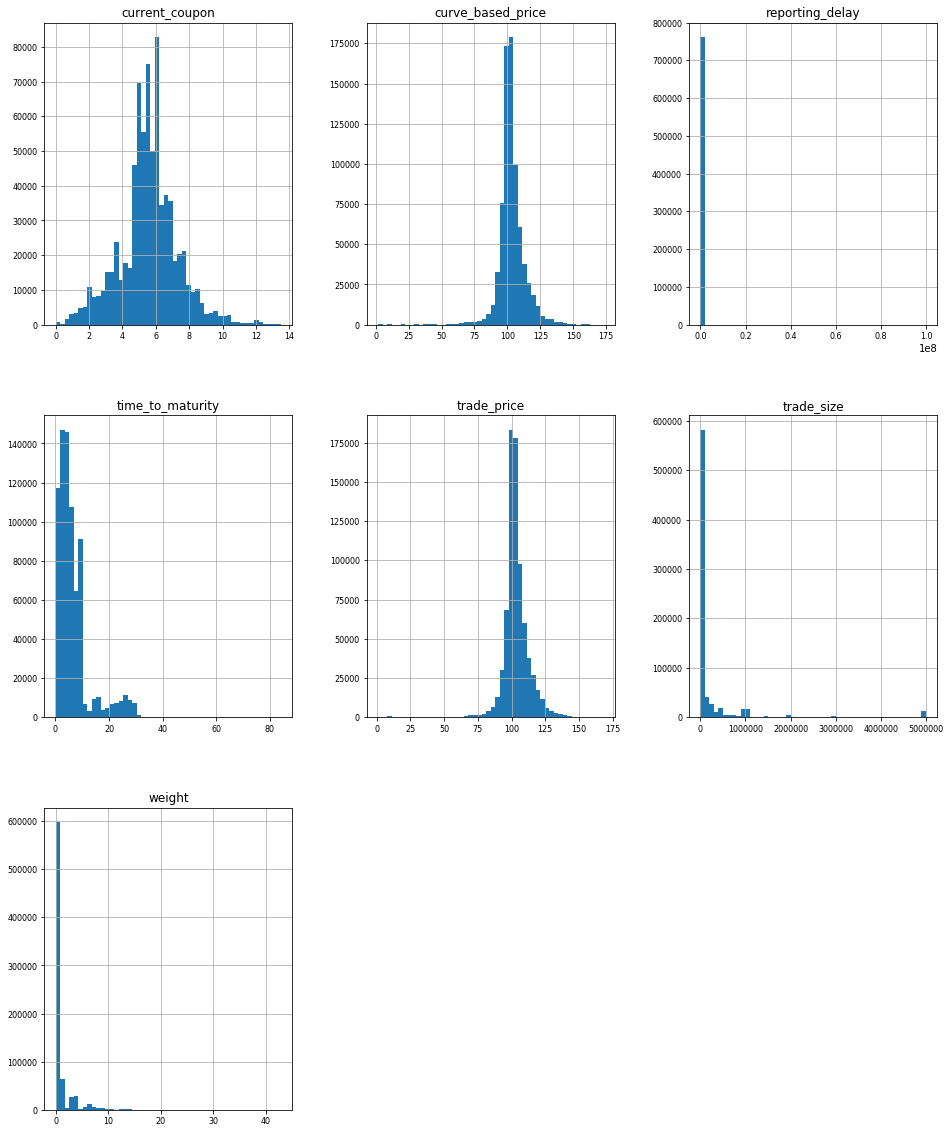

In [105]:
data3_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

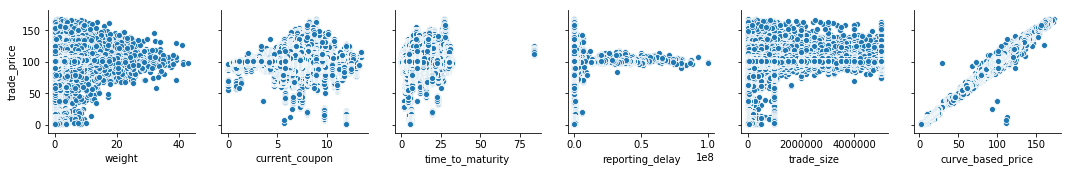

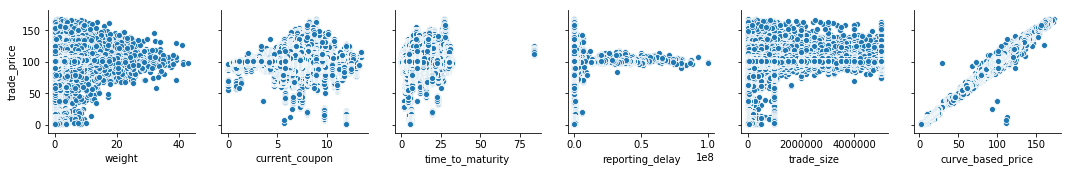

In [106]:
for i in range(0, len(data3_num.columns), 5):
    sns.pairplot(data=data3_num,x_vars=data3_num.drop(columns=["trade_price"],axis=1).columns,y_vars=['trade_price'])

### We find that only curve_based_price is having a linear contribution towards "trade_price"

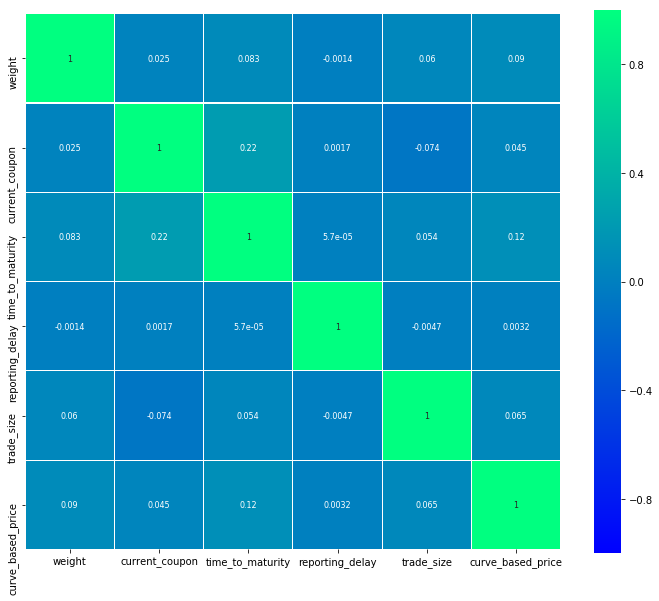

In [107]:
corr = data3_num.drop(columns=["trade_price"], axis=1).corr()
plt.figure(figsize=(12, 10))

sns.heatmap(corr, cmap='winter', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

### None of these numeric columns are correlated

### Lets investigate the categorical features:

In [108]:
cat_cols

['is_callable', 'trade_type']

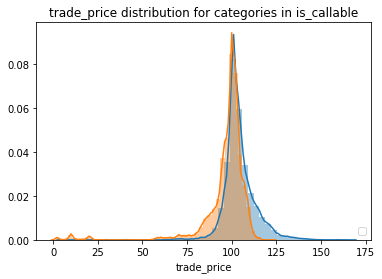

In [109]:
for k, df in data3.groupby(['is_callable']):
    fig = sns.distplot(df["trade_price"])
    fig.set_title("trade_price distribution for categories in is_callable")
    fig.legend(loc=4)
    

Text(0.5, 1.0, 'Mean trade price with respect to Bond Callability')

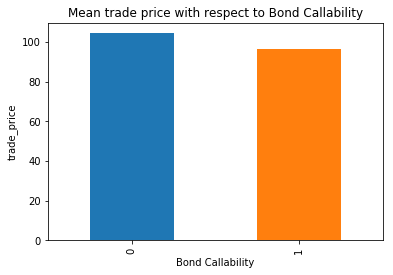

In [110]:
mean_price_df = pd.DataFrame(data3.groupby(['is_callable'])["trade_price"].mean())
ax = mean_price_df.unstack().plot(kind='bar')

ax.set_xticklabels(mean_price_df.index)
ax.set_xlabel('Bond Callability')

ax.set_ylabel('trade_price')

ax.set_title('Mean trade price with respect to Bond Callability')

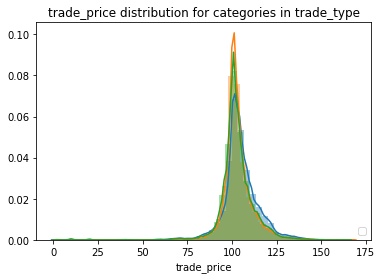

In [111]:
for k, df in data3.groupby(['trade_type']):
    fig = sns.distplot(df["trade_price"])
    fig.set_title("trade_price distribution for categories in trade_type")
    fig.legend(loc=4)

Text(0.5, 1.0, 'Mean trade price with respect to Bond Trade Type')

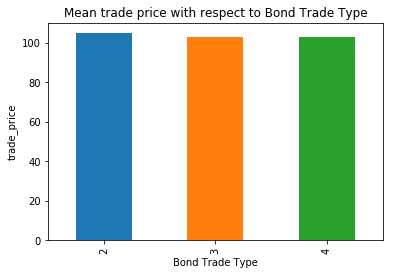

In [112]:
mean_price_df = pd.DataFrame(data3.groupby(['trade_type'])["trade_price"].mean())
ax = mean_price_df.unstack().plot(kind='bar')

ax.set_xticklabels(mean_price_df.index)
ax.set_xlabel('Bond Trade Type')

ax.set_ylabel('trade_price')

ax.set_title('Mean trade price with respect to Bond Trade Type')

In [113]:
X_main = pd.get_dummies(d3[working_cols].drop(columns=["trade_price","weight"], axis=1), columns=cat_cols).values
y = d3[target_col].values
sample_weights = d3["weight"].values

In [114]:
ts_data = {}

In [115]:
for col in ts_cols:
    ts_data[col.split("_last")[0]] = np.fliplr(d3[d3.columns[d3.columns.str.contains(pat = col)]].values)

In [116]:
ts_data

{'trade_size': array([[      0.,       0.,       0., ...,       0.,       0.,  200000.],
        [      0.,       0.,       0., ...,       0.,  200000.,  120000.],
        [      0.,       0.,       0., ...,  200000.,  120000.,   85000.],
        ...,
        [  50000.,   50000.,  180000., ...,  165000.,   50000.,  500000.],
        [  50000.,  180000.,   15000., ...,   50000.,  500000., 3700000.],
        [ 180000.,   15000., 2000000., ...,  500000., 3700000., 2000000.]]),
 'trade_price': array([[  0.   ,   0.   ,   0.   , ...,   0.   ,   0.   , 129.089],
        [  0.   ,   0.   ,   0.   , ...,   0.   , 129.089, 128.596],
        [  0.   ,   0.   ,   0.   , ..., 129.089, 128.596, 126.673],
        ...,
        [101.391, 101.391, 101.328, ..., 101.257, 101.334, 101.303],
        [101.391, 101.328, 101.259, ..., 101.334, 101.303, 101.503],
        [101.328, 101.259, 101.541, ..., 101.303, 101.503, 101.479]]),
 'received_time_diff': array([[0.000000e+00, 0.000000e+00, 0.000000e+00, ...,

In [117]:
input_ts_1 = Input(shape=(ts_data["trade_size"].shape[1],1))
lstm_1_ts_1 = Bidirectional(LSTM(100,activation='relu',return_sequences=True))(input_ts_1)
lstm_2_ts_1 = LSTM(50, activation='relu')(lstm_1_ts_1)
out_ts_1 = Dense(1)(lstm_2_ts_1)

input_ts_2 = Input(shape=(ts_data["received_time_diff"].shape[1],1))
lstm_1_ts_2 = Bidirectional(LSTM(100,activation='relu',return_sequences=True))(input_ts_2)
lstm_2_ts_2 = LSTM(50, activation='relu')(lstm_1_ts_2)
out_ts_2 = Dense(1)(lstm_2_ts_2)

input_ts_3 = Input(shape=(ts_data["trade_type"].shape[1],1))
lstm_1_ts_3 = Bidirectional(LSTM(100,activation='relu',return_sequences=True))(input_ts_3)
lstm_2_ts_3 = LSTM(50, activation='relu')(lstm_1_ts_3)
out_ts_3 = Dense(1)(lstm_2_ts_3)

input_ts_4 = Input(shape=(ts_data["curve_based_price"].shape[1],1))
lstm_1_ts_4 = Bidirectional(LSTM(100,activation='relu',return_sequences=True))(input_ts_4)
lstm_2_ts_4 = LSTM(50, activation='relu')(lstm_1_ts_4)
out_ts_4 = Dense(1)(lstm_2_ts_4)

input_ts_5 = Input(shape=(ts_data["trade_price"].shape[1],1))
lstm_1_ts_5 = Bidirectional(LSTM(100,activation='relu',return_sequences=True))(input_ts_5)
lstm_2_ts_5 = LSTM(50, activation='relu')(lstm_1_ts_5)
out_ts_5 = Dense(1)(lstm_2_ts_5)

merged_ts = concatenate([out_ts_1, out_ts_2, out_ts_3, out_ts_4, out_ts_5])
ts_dense_1 = Dense(50)(merged_ts)
ts_dense_2 = Dense(50)(ts_dense_1)
out_ts_6 = Dense(1)(ts_dense_2)

input_main = Input(shape=(X_main.shape[1],))
main_dense_1 = Dense(50, activation='relu')(input_main)
main_dense_2 = Dense(50, activation='relu')(main_dense_1)
out_main = Dense(1)(main_dense_2)

merged_full = concatenate([out_ts_6, out_main])
full_dense_1 = Dense(50)(merged_full)
full_dense_2 = Dense(50)(full_dense_1)
full_out = Dense(1)(full_dense_2)

model_full = Model(inputs=[input_ts_1,input_ts_2,input_ts_3,input_ts_4,input_ts_5,input_main], 
                   outputs=full_out)
model_full.compile(optimizer='rmsprop', 
                   loss=['msle'],
                   metrics=['mse','mae','mape','cosine'])
print(model_full.summary())
plot_model(model_full, to_file='Plots/Model_Designs/Full_Model.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 10, 1)        0                                            
__________________________________________________________________________________________________
input_5 (I

In [118]:
def train_test_splitter(X,label,type_data,is_norm):
    train_size = int(X.shape[0] * 0.75)
    X_train = X[0:train_size]
    X_test = X[train_size:]
    
    if is_norm:
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
        scaler_filename = "scaler3_"+label+".save"
        scaler_path = "Scalers/" + scaler_filename
        joblib.dump(scaler, scaler_path)
    
    if (type_data == "timeseries"):
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    return X_train,X_test 

In [119]:
# checkpoint
filepath="Models/Model_data3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tensorboard = TensorBoard(log_dir='./logs/', histogram_freq=0, write_graph=True, write_images=True)
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.05, patience=5, verbose=0, mode='min')
callbacks_list = [checkpoint,tensorboard,reduceLR,earlystop]

# fit model
history = model_full.fit([train_test_splitter(ts_data["trade_size"],"trade_size","timeseries",True)[0],
                          train_test_splitter(ts_data["received_time_diff"],"received_time_diff","timeseries",True)[0],
                          train_test_splitter(ts_data["trade_type"],"trade_type","timeseries",True)[0],
                          train_test_splitter(ts_data["curve_based_price"],"curve_based_price","timeseries",True)[0],
                          train_test_splitter(ts_data["trade_price"],"trade_price","timeseries",True)[0],
                          train_test_splitter(X_main,"main","general",True)[0]],
                         train_test_splitter(y,"None","general",False)[0],
                         epochs=get_model_params()[0],
                         batch_size=get_model_params()[1],
                         verbose=1,
                         validation_data=([train_test_splitter(ts_data["trade_size"],"trade_size","timeseries",True)[1],
                                           train_test_splitter(ts_data["received_time_diff"],"received_time_diff","timeseries",True)[1],
                                           train_test_splitter(ts_data["trade_type"],"trade_type","timeseries",True)[1],
                                           train_test_splitter(ts_data["curve_based_price"],"curve_based_price","timeseries",True)[1],
                                           train_test_splitter(ts_data["trade_price"],"trade_price","timeseries",True)[1],
                                           train_test_splitter(X_main,"main","general",True)[1]],
                                          train_test_splitter(y,"None","general",False)[1]),
                         callbacks=callbacks_list,
                         sample_weight=train_test_splitter(sample_weights,"None","general",False)[0])

Train on 572008 samples, validate on 190670 samples
Epoch 1/20
572008/572008 [==============================] - 713s 1ms/step - loss: 2.1874 - mean_squared_error: 2835.3288 - mean_absolute_error: 41.3954 - mean_absolute_percentage_error: 42.9446 - cosine_proximity: -0.9990 - val_loss: 0.1952 - val_mean_squared_error: 3292.4648 - val_mean_absolute_error: 54.6471 - val_mean_absolute_percentage_error: 54.8530 - val_cosine_proximity: -1.0000

Epoch 00001: val_loss improved from inf to 0.19521, saving model to Model_data3.h5
Epoch 2/20
572008/572008 [==============================] - 684s 1ms/step - loss: 0.0635 - mean_squared_error: 636.5003 - mean_absolute_error: 19.4022 - mean_absolute_percentage_error: 22.1692 - cosine_proximity: -1.0000 - val_loss: 0.0676 - val_mean_squared_error: 891.9376 - val_mean_absolute_error: 29.0470 - val_mean_absolute_percentage_error: 29.2807 - val_cosine_proximity: -1.0000

Epoch 00002: val_loss improved from 0.19521 to 0.06762, saving model to Model_data3.h

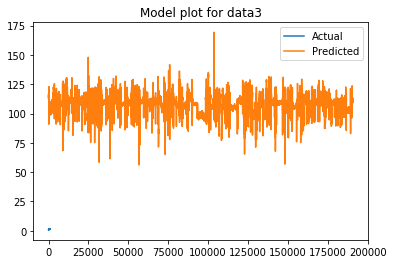

In [120]:
try:
    y_pred = model_full.predict([train_test_splitter(ts_data["trade_size"],"trade_size","timeseries",True)[1],
                                 train_test_splitter(ts_data["received_time_diff"],"received_time_diff","timeseries",True)[1],
                                 train_test_splitter(ts_data["trade_type"],"trade_type","timeseries",True)[1],
                                 train_test_splitter(ts_data["curve_based_price"],"curve_based_price","timeseries",True)[1],
                                 train_test_splitter(ts_data["trade_price"],"trade_price","timeseries",True)[1],
                                 train_test_splitter(X_main,"main","general",True)[1]])
except Exception as e:
    print("Error in predicting data3 : ",str(e))

plt.plot(y_test)
plt.plot(y_pred)

plt.title('Model plot for data3')
plt.legend(['Actual', 'Predicted'], loc='upper right');

plt.savefig("Plots/Training_Evaluation/Model_Train_Plot_data3.png")

In [121]:
history_data3 = history.history

In [122]:
history_data3 = pd.DataFrame(history_data3)
history_data3.head()

,val_loss,val_mean_squared_error,val_mean_absolute_error,val_mean_absolute_percentage_error,val_cosine_proximity,loss,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,cosine_proximity,lr
0,0.195214,3292.464781,54.647088,54.852969,-1.0,2.187398,2835.328813,41.395376,42.944605,-0.998955,0.001
1,0.067621,891.937563,29.046976,29.280738,-1.0,0.063486,636.500311,19.402207,22.169228,-1.000000,0.001
2,0.121363,1753.276332,41.493501,41.727590,-1.0,0.049328,477.237579,15.438628,18.419214,-1.000000,0.001
3,0.020911,236.136217,14.797627,15.022670,-1.0,0.037868,338.054478,14.460878,17.204697,-1.000000,0.001
4,0.004351,42.745655,5.540671,5.471146,-1.0,0.033703,287.542608,13.840502,16.483600,-1.000000,0.001


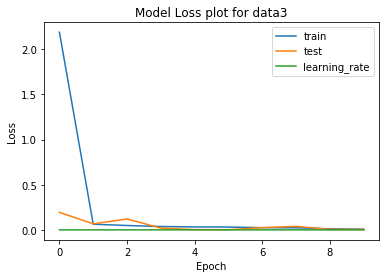

In [123]:
plt.plot(history_data3['loss'])
plt.plot(history_data3['val_loss'])
plt.plot(history_data3['lr'])
plt.title('Model Loss plot for data3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test', 'learning_rate'], loc='upper right');

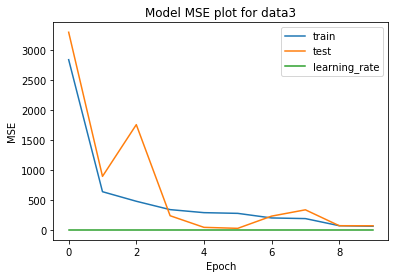

In [124]:
plt.plot(history_data3['mean_squared_error'])
plt.plot(history_data3['val_mean_squared_error'])
plt.plot(history_data3['lr'])
plt.title('Model MSE plot for data3')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'test', 'learning_rate'], loc='upper right');

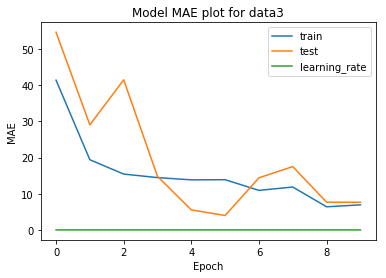

In [125]:
plt.plot(history_data3['mean_absolute_error'])
plt.plot(history_data3['val_mean_absolute_error'])
plt.plot(history_data3['lr'])
plt.title('Model MAE plot for data3')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'test', 'learning_rate'], loc='upper right');

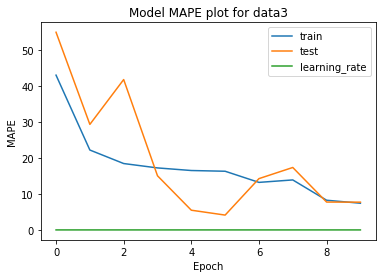

In [126]:
plt.plot(history_data3['mean_absolute_percentage_error'])
plt.plot(history_data3['val_mean_absolute_percentage_error'])
plt.plot(history_data3['lr'])
plt.title('Model MAPE plot for data3')
plt.ylabel('MAPE')
plt.xlabel('Epoch')
plt.legend(['train', 'test', 'learning_rate'], loc='upper right');

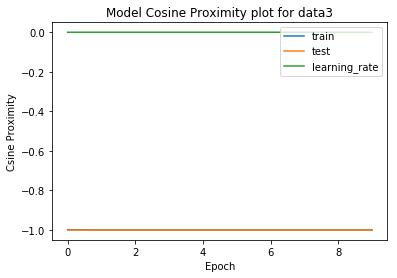

In [127]:
plt.plot(history_data3['cosine_proximity'])
plt.plot(history_data3['val_cosine_proximity'])
plt.plot(history_data3['lr'])
plt.title('Model Cosine Proximity plot for data3')
plt.ylabel('Csine Proximity')
plt.xlabel('Epoch')
plt.legend(['train', 'test', 'learning_rate'], loc='upper right');

In [128]:
model3 = load_model('Models/Model_data3.h5')

## Saving Model

In [131]:
# Saving a Keras Model
model3_json = model3.to_json()
with open("Models/model3_json.json", "w") as json_file:
    json_file.write(model3_json)

# Serialize weights to HDF5
print("Saved model_3 weights to disk")
model3.save_weights("Models/model3_weights.h5")

# Serialize model to HDF5
print("Saved model_3 to disk")
model3.save_weights("Models/model3.h5")

Saved model_3 weights to disk
Saved model_3 to disk
